In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.distributions.uniform import Uniform
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.integrate import odeint

In [2]:
torch.manual_seed(8407)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
class Kepler2D(Dataset):
    def __init__(self, t, z0, G=1, M=1):
        tmin, tmax, tnum = t
        
        def eom(z, t):
            x, y, vx, vy = z
            dxdt = vx
            dydt = vy
            dvxdt = - G * M / (x**2 + y**2)**(3/2) * x
            dvydt = - G * M / (x**2 + y**2)**(3/2) * y
            return [dxdt, dydt, dvxdt, dvydt]
        
        t = torch.linspace(tmin, tmax, tnum)
        X = torch.Tensor(odeint(eom, z0, t)).float()
        
        # Positive Pair
        idx = torch.randperm(len(t))
        X_p = X[idx, :]
        
        # Negative Pair - 1. x
        idx_x = torch.randperm(len(t))
        X_x = X.clone()
        X_x[:,0] = X_x[idx_x, 0]
        
        # Negative Pair - 2. y
        idx_y = torch.randperm(len(t))
        X_y = X.clone()
        X_y[:,1] = X_y[idx_y, 1]
        
        # Negative Pair - 3. vx
        idx_vx = torch.randperm(len(t))
        X_vx = X.clone()
        X_vx[:,2] = X_vx[idx_vx, 2]
        
        # Negative Pair - 4. vy
        idx_vy = torch.randperm(len(t))
        X_vy = X.clone()
        X_vy[:,3] = X_y[idx_vy, 3]
        
        # Mix Negative Pair
        X_n_tot = torch.stack([X_x, X_y, X_vx, X_vy], dim=2)
        idx_neg = torch.randint(4, (len(t),))
        X_n = torch.Tensor(X.shape[0], X.shape[1])
        for i in range(X.shape[0]):
            X_n[i, :] = X_n_tot[i, :, idx_neg[i]]
            
        # Mix Pairs with label
        self.X = torch.vstack([X, X])
        self.X_pair = torch.vstack([X_p, X_n])
        
        # Labelling
        y_p = torch.zeros((X_p.shape[0], 1))
        y_n = torch.ones((X_n.shape[0], 1))
        self.y = torch.vstack([y_p, y_n])
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        x = torch.Tensor(self.X[idx])
        x_pair = torch.Tensor(self.X_pair[idx])
        y = torch.Tensor(self.y[idx])
        return x, x_pair, y

In [4]:
class SNN(nn.Module):
    def __init__(self):
        super(SNN, self).__init__()
        self.linear_relu = nn.Sequential(
            nn.Linear(4,100),
            nn.ReLU(),
            nn.Linear(100,1),
            nn.LeakyReLU()
        )

    def forward(self, x1, x2):
        out1 = self.linear_relu(x1)
        out2 = self.linear_relu(x2)
        return out1, out2

In [5]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

In [6]:
def r2_score(target, output):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [7]:
z0 = [1.3, 1.9, -0.23, 0.17]
print(z0)
t_test = (0, 10, 5000)

[1.3, 1.9, -0.23, 0.17]


In [8]:
test_dataset = Kepler2D(t_test, z0)
test_dataloader = DataLoader(test_dataset, batch_size=500)

In [9]:
net = torch.load("model/snn_kepl2d_02.pt").to(device)
criterion = ContrastiveLoss()

In [10]:
total_accuracy = 0
total_size = len(test_dataloader.dataset)
for batch, samples in enumerate(test_dataloader):
    x, x_p, y = samples
    x, x_p, y = x.to(device), x_p.to(device), y.to(device)
    with torch.no_grad():
        out1, out2 = net(x, x_p)
        idx = torch.flatten((torch.abs(out1 - out2) <= 0.2) != y)
        acc = torch.count_nonzero(idx)
        # print(f"Accuracy: {100-acc}%")
        total_accuracy += acc
        # temp = torch.column_stack([pred1, pred2, y])
        # temp_val = temp[idx]
        # if len(temp_val) != 0:
        #     print(f"{batch} - {temp_val[:].tolist()}")
print(f"Average Accuracy: {total_accuracy/total_size*100}%")

Average Accuracy: 99.45999908447266%


In [11]:
# def r2_score(output, target):
#     target_mean = torch.mean(target)
#     ss_tot = torch.sum((target - target_mean) ** 2)
#     ss_res = torch.sum((target - output) ** 2)
#     r2 = 1 - ss_res / ss_tot
#     return r2

In [12]:
X, X_p, Y = test_dataset[:]
X, X_p, Y = X.to(device), X_p.to(device), Y.to(device)

x, y, vx, vy = X_p[:, 0], X_p[:,1], X_p[:,2], X_p[:,3]
x, y, vx, vy = x.to(device), y.to(device), vx.to(device), vy.to(device)

net.eval()
with torch.no_grad():
    _, Z = net(X, X_p)
Z

tensor([[ 3.9059e+01],
        [ 3.9025e+01],
        [ 3.9052e+01],
        ...,
        [-2.0380e-04],
        [ 3.5721e+01],
        [ 6.6224e+00]])

In [13]:
X_linear = torch.column_stack([torch.ones((len(x), 1)).float().to(device), x, y, vx, vy])

In [14]:
weight_linear = torch.mm(torch.linalg.pinv(X_linear), Z)
weight_linear

tensor([[  9.2124],
        [ 12.2876],
        [ 14.4302],
        [ 23.0380],
        [-19.1195]])

In [15]:
r2_score(torch.mm(X_linear, weight_linear), Z)

tensor(0.3540)

In [30]:
X_quad = torch.column_stack([torch.ones((len(x), 1)).float().to(device), x, y, vx, vy, x**2, x*y, x*vx, x*vy, y**2, y*vx, y*vy, vx**2, vx*vy, vy**2])

In [31]:
X_quad.shape

torch.Size([10000, 11])

In [32]:
weight_quad = torch.mm(torch.linalg.pinv(X_quad), Z)
weight_quad

tensor([[ 15.3642],
        [  3.1148],
        [  9.9057],
        [ 20.6098],
        [ -0.9673],
        [  3.6534],
        [ 10.4066],
        [-21.2077],
        [  3.3475],
        [  0.5208],
        [  4.1161]])

In [33]:
r2_score(Z, torch.mm(X_quad, weight_quad))

tensor(0.8943)

In [20]:
class PolyNet(nn.Module):
    def __init__(self):
        super(PolyNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(14, 1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.model(x)

In [21]:
net2 = PolyNet().to(device)

In [22]:
print(net2)

PolyNet(
  (model): Sequential(
    (0): Linear(in_features=14, out_features=1, bias=True)
    (1): ReLU()
  )
)


In [23]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net2.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

In [24]:
t_train = (0, 10, 50000)
t_valid = (0, 10, 5000)

train_dataset = Kepler2D(t_train, z0)
valid_dataset = Kepler2D(t_valid, z0)

train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=500)

dataloaders_dict = {
    "train": train_dataloader,
    "val": valid_dataloader
}

In [25]:
def train(net, net2, dataloaders_dict, criterion, optimizer, num_epochs):
    train_loss = []
    val_loss = []
    net.eval()
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("----------------------")
        
        for phase in ['train', 'val']:
            if phase == 'train':
                net2.train()
            else:
                net2.eval()
                
            epoch_loss = 0.0
            epoch_r2 = 0.0
            
            data = dataloaders_dict[phase]
            for batch, samples in enumerate(tqdm(data)):
                X, X_p, y = samples
                X, X_p, y = X.to(device), X_p.to(device), y.to(device)
                
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=="train"):
                    with torch.no_grad():
                        _, out = net(X, X_p)
                        x, y, vx, vy = X_p[:, 0], X_p[:,1], X_p[:,2], X_p[:,3]
                    X_quad = torch.column_stack([x, y, vx, vy, x**2, x*y, x*vx, x*vy, y**2, y*vx, y*vy, vx**2, vx*vy, vy**2])
                    Z = net2(X_quad)
                    loss = criterion(Z, out)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                    
                epoch_loss += loss.item() + X.shape[0]
                epoch_r2 += r2_score(Z, out)
                    
            epoch_loss = epoch_loss / len(data.dataset)
            epoch_r2 = epoch_r2 / len(data)
            
            if phase == 'train':
                train_loss.append(epoch_loss)
            else:
                val_loss.append(epoch_loss)
                scheduler.step(epoch_loss)
                lr = scheduler._last_lr[0]
                print(f" Validation Loss: {epoch_loss:>8f}")
                print(f" Validation R2  : {epoch_r2:>8f}")
                print(f" Learning Rate  : {lr:>8f}\n")
                if lr < 1e-6:
                    return train_loss, val_loss
            
    return train_loss, val_loss

In [26]:
train_loss, val_loss = train(net, net2, dataloaders_dict, criterion, optimizer, 500)

 12%|█▏        | 24/200 [00:00<00:00, 237.96it/s]

Epoch 1/500
----------------------


 13%|█▎        | 26/200 [00:00<00:00, 253.50it/s]

 Validation Loss: 1.030586
 Validation R2  : 0.446413
 Learning Rate  : 1.000000

Epoch 2/500
----------------------


 11%|█         | 22/200 [00:00<00:00, 213.58it/s]

 Validation Loss: 1.026337
 Validation R2  : 0.362604
 Learning Rate  : 1.000000

Epoch 3/500
----------------------


 11%|█         | 22/200 [00:00<00:00, 213.03it/s]

 Validation Loss: 1.022629
 Validation R2  : 0.476688
 Learning Rate  : 1.000000

Epoch 4/500
----------------------


 11%|█         | 22/200 [00:00<00:00, 218.69it/s]

 Validation Loss: 1.020658
 Validation R2  : 0.456691
 Learning Rate  : 1.000000

Epoch 5/500
----------------------


 11%|█         | 22/200 [00:00<00:00, 219.16it/s]

 Validation Loss: 1.019626
 Validation R2  : 0.463250
 Learning Rate  : 1.000000

Epoch 6/500
----------------------


 12%|█▏        | 23/200 [00:00<00:00, 221.19it/s]

 Validation Loss: 1.019883
 Validation R2  : 0.471231
 Learning Rate  : 1.000000

Epoch 7/500
----------------------


 10%|█         | 20/200 [00:00<00:00, 195.71it/s]

 Validation Loss: 1.020486
 Validation R2  : 0.457781
 Learning Rate  : 1.000000

Epoch 8/500
----------------------


 11%|█         | 22/200 [00:00<00:00, 215.00it/s]

 Validation Loss: 1.020197
 Validation R2  : 0.417696
 Learning Rate  : 1.000000

Epoch 9/500
----------------------


 11%|█         | 22/200 [00:00<00:00, 214.73it/s]

 Validation Loss: 1.019577
 Validation R2  : 0.438360
 Learning Rate  : 0.100000

Epoch 10/500
----------------------


 11%|█         | 22/200 [00:00<00:00, 212.88it/s]

 Validation Loss: 1.018831
 Validation R2  : 0.463925
 Learning Rate  : 0.100000

Epoch 11/500
----------------------


 10%|█         | 21/200 [00:00<00:00, 201.65it/s]

 Validation Loss: 1.018849
 Validation R2  : 0.457615
 Learning Rate  : 0.100000

Epoch 12/500
----------------------


 11%|█         | 22/200 [00:00<00:00, 213.13it/s]

 Validation Loss: 1.018839
 Validation R2  : 0.461760
 Learning Rate  : 0.100000

Epoch 13/500
----------------------


 10%|█         | 21/200 [00:00<00:00, 205.62it/s]

 Validation Loss: 1.018884
 Validation R2  : 0.439862
 Learning Rate  : 0.100000

Epoch 14/500
----------------------


 10%|█         | 21/200 [00:00<00:00, 207.80it/s]

 Validation Loss: 1.019113
 Validation R2  : 0.469332
 Learning Rate  : 0.010000

Epoch 15/500
----------------------


  9%|▉         | 18/200 [00:00<00:01, 175.68it/s]

 Validation Loss: 1.018795
 Validation R2  : 0.464581
 Learning Rate  : 0.010000

Epoch 16/500
----------------------


 10%|█         | 21/200 [00:00<00:00, 182.21it/s]

 Validation Loss: 1.018818
 Validation R2  : 0.461336
 Learning Rate  : 0.010000

Epoch 17/500
----------------------


  9%|▉         | 18/200 [00:00<00:01, 173.56it/s]

 Validation Loss: 1.018805
 Validation R2  : 0.463198
 Learning Rate  : 0.010000

Epoch 18/500
----------------------


  8%|▊         | 16/200 [00:00<00:01, 156.85it/s]

 Validation Loss: 1.018824
 Validation R2  : 0.459518
 Learning Rate  : 0.001000

Epoch 19/500
----------------------


  9%|▉         | 18/200 [00:00<00:01, 173.19it/s]

 Validation Loss: 1.018818
 Validation R2  : 0.460640
 Learning Rate  : 0.001000

Epoch 20/500
----------------------


  8%|▊         | 17/200 [00:00<00:01, 165.19it/s]

 Validation Loss: 1.018824
 Validation R2  : 0.457478
 Learning Rate  : 0.001000

Epoch 21/500
----------------------


  8%|▊         | 17/200 [00:00<00:01, 166.40it/s]

 Validation Loss: 1.018815
 Validation R2  : 0.460830
 Learning Rate  : 0.001000

Epoch 22/500
----------------------


 11%|█         | 22/200 [00:00<00:00, 216.60it/s]

 Validation Loss: 1.018819
 Validation R2  : 0.458516
 Learning Rate  : 0.000100

Epoch 23/500
----------------------


 10%|█         | 20/200 [00:00<00:00, 198.16it/s]

 Validation Loss: 1.018819
 Validation R2  : 0.458501
 Learning Rate  : 0.000100

Epoch 24/500
----------------------


 11%|█         | 22/200 [00:00<00:00, 217.66it/s]

 Validation Loss: 1.018818
 Validation R2  : 0.458613
 Learning Rate  : 0.000100

Epoch 25/500
----------------------


 11%|█         | 22/200 [00:00<00:00, 212.32it/s]

 Validation Loss: 1.018817
 Validation R2  : 0.458943
 Learning Rate  : 0.000100

Epoch 26/500
----------------------


 10%|█         | 21/200 [00:00<00:00, 205.28it/s]

 Validation Loss: 1.018818
 Validation R2  : 0.458775
 Learning Rate  : 0.000010

Epoch 27/500
----------------------


 10%|█         | 21/200 [00:00<00:00, 205.15it/s]

 Validation Loss: 1.018818
 Validation R2  : 0.458779
 Learning Rate  : 0.000010

Epoch 28/500
----------------------


 10%|█         | 21/200 [00:00<00:00, 206.06it/s]

 Validation Loss: 1.018818
 Validation R2  : 0.458745
 Learning Rate  : 0.000010

Epoch 29/500
----------------------


 11%|█         | 22/200 [00:00<00:00, 212.77it/s]

 Validation Loss: 1.018818
 Validation R2  : 0.458800
 Learning Rate  : 0.000010

Epoch 30/500
----------------------


 11%|█         | 22/200 [00:00<00:00, 216.14it/s]

 Validation Loss: 1.018818
 Validation R2  : 0.458752
 Learning Rate  : 0.000001

Epoch 31/500
----------------------


 11%|█         | 22/200 [00:00<00:00, 212.73it/s]

 Validation Loss: 1.018818
 Validation R2  : 0.458752
 Learning Rate  : 0.000001

Epoch 32/500
----------------------


 10%|█         | 21/200 [00:00<00:00, 208.61it/s]

 Validation Loss: 1.018818
 Validation R2  : 0.458750
 Learning Rate  : 0.000001

Epoch 33/500
----------------------


 11%|█         | 22/200 [00:00<00:00, 216.64it/s]

 Validation Loss: 1.018818
 Validation R2  : 0.458749
 Learning Rate  : 0.000001

Epoch 34/500
----------------------


100%|██████████| 20/20 [00:00<00:00, 234.99it/s]

 Validation Loss: 1.018818
 Validation R2  : 0.458748
 Learning Rate  : 0.000000



In [27]:
for param in net2.parameters():
  print(param.data)

tensor([[ 21.6549,  32.9074,  36.7539, -24.0399,  -0.9112,  -2.2625,   6.9332,
           4.2189,  -4.7150,   2.2581, -11.9745,  -5.7231,  10.5579,  -1.8493]])
tensor([-7.5295])


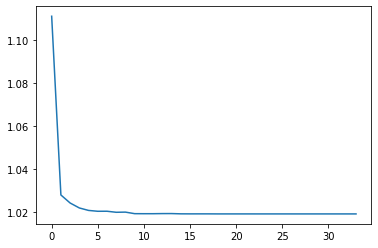

In [28]:
plt.plot(train_loss)

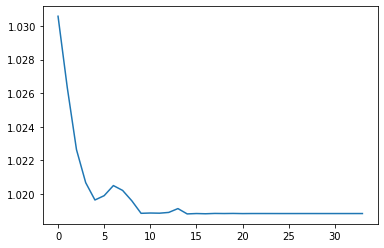

In [29]:
plt.plot(val_loss)

In [36]:
X[:5000]

tensor([[ 1.3000,  1.9000, -0.2300,  0.1700],
        [ 1.2995,  1.9003, -0.2302,  0.1697],
        [ 1.2991,  1.9007, -0.2304,  0.1694],
        ...,
        [ 1.0211,  1.9893, -0.3278,  0.0058],
        [ 1.0204,  1.9893, -0.3280,  0.0055],
        [ 1.0198,  1.9894, -0.3281,  0.0051]])

In [37]:
X_p[:5000]

tensor([[ 0.2548,  1.6208, -0.4771, -0.4522],
        [ 0.9297,  0.1247,  0.8222,  0.8181],
        [ 1.4712,  1.6576, -0.1124,  0.3206],
        ...,
        [ 0.4253, -0.2186,  1.7190,  0.6635],
        [ 1.1737,  1.9647, -0.2804,  0.0912],
        [ 1.2480,  1.9330, -0.2525,  0.1362]])

In [38]:
X[5000:]

tensor([[ 1.3000,  1.9000, -0.2300,  0.1700],
        [ 1.2995,  1.9003, -0.2302,  0.1697],
        [ 1.2991,  1.9007, -0.2304,  0.1694],
        ...,
        [ 1.0211,  1.9893, -0.3278,  0.0058],
        [ 1.0204,  1.9893, -0.3280,  0.0055],
        [ 1.0198,  1.9894, -0.3281,  0.0051]])

In [39]:
X_p[5000:]

tensor([[ 1.3000,  1.9000,  0.1328,  0.1700],
        [ 1.2995,  1.9003, -0.2302, -0.0258],
        [ 1.1915,  1.9007, -0.2304,  0.1694],
        ...,
        [ 1.0211,  1.9893, -0.3278,  0.7712],
        [ 0.8104,  1.9893, -0.3280,  0.0055],
        [ 1.0198,  1.9894, -0.3281,  0.5927]])